### import

In [3]:
import numpy as np
import torch
import random
import csv
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

### 기본 함수들

In [4]:
# 데이터 로드 함수
def load_data(filepath):
    with open(filepath, mode='r', newline='') as file:
        data = [list(map(float, row)) for row in csv.reader(file)]
    tensor_data = torch.tensor(data, dtype=torch.float32)
    return tensor_data

# 경로 시각화 함수
def plot_path(path, coordinates):
    coordinates = coordinates.numpy()
    path = np.array(path + [path[0]])
    plt.figure(figsize=(10, 10))
    plt.plot(coordinates[path, 0], coordinates[path, 1], 'o-')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Optimized Path')
    plt.show()

# 거리 계산 함수
def distance(city1, city2):
    return np.linalg.norm(city1 - city2)

# 비용 계산 함수
def calculate_cost(path, coordinates):
    return np.sum([distance(coordinates[path[i]], coordinates[path[i+1]]) for i in range(len(path)-1)])

# Nearest Neighbor 알고리즘을 사용한 초기 경로 생성 함수
def nearest_neighbor(cities):
    num_cities = len(cities)
    unvisited_cities = set(range(1, num_cities))
    current_city = 0
    tour = [current_city]
    while unvisited_cities:
        nearest_city = min(unvisited_cities, key=lambda city: distance(cities[current_city], cities[city]))
        tour.append(nearest_city)
        unvisited_cities.remove(nearest_city)
        current_city = nearest_city
    tour.append(0)
    return tour

# 유전 알고리즘의 변이 연산 함수
def mutate(path, mutation_rate):
    new_path = path[:]
    num_cities = len(path)
    for _ in range(int((num_cities - 2) * mutation_rate)):
        swap_idx1, swap_idx2 = random.sample(range(1, num_cities - 1), 2)
        new_path[swap_idx1], new_path[swap_idx2] = new_path[swap_idx2], new_path[swap_idx1]
    return new_path

# 유전 알고리즘의 교차 연산 함수
def crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[start:end] = parent1[start:end]
    ptr = end
    for city in parent2:
        if city not in child:
            if ptr >= size:
                ptr = 0
            child[ptr] = city
            ptr += 1
    return child

# 유전 알고리즘 함수
def genetic_algorithm(coordinates, max_iterations, num_expansions, mutation_rate):
    initial_path = nearest_neighbor(coordinates)
    best_path = initial_path
    best_cost = calculate_cost(initial_path, coordinates)

    for iteration in range(max_iterations):
        for _ in range(num_expansions):
            new_path = mutate(best_path, mutation_rate)
            new_cost = calculate_cost(new_path, coordinates)
            if new_cost < best_cost:
                best_path = new_path
                best_cost = new_cost

    return best_cost, best_path

def generate_path_from_policy(policy):
    num_cities = len(policy)
    start_city = 0
    path = [start_city]
    current_city = start_city
    visited = set(path)
    
    while len(visited) < num_cities:
        next_city = policy[current_city]
        if next_city in visited:
            unvisited_cities = set(range(num_cities)) - visited
            if unvisited_cities:
                next_city = unvisited_cities.pop()
            else:
                break
        path.append(next_city)
        visited.add(next_city)
        current_city = next_city
    
    return path

### Q-Value Iteration 관련 함수들

In [22]:
# 초기 Value Table 및 Policy 초기화 함수
def initialize_value_policy(num_cities):
    value_table = np.full((num_cities, num_cities), float('inf'))
    np.fill_diagonal(value_table, 0)
    policy = np.zeros(num_cities, dtype=int)
    return value_table, policy

# Value Table 및 Policy 업데이트 함수
def update_value_policy(value_table, policy, path, coordinates):
    num_cities = len(coordinates)
    for i in range(num_cities):
        current_city = path[i]
        next_city = path[(i + 1) % num_cities]
        cost = distance(coordinates[current_city], coordinates[next_city])
        value_table[current_city][next_city] = cost
        policy[current_city] = next_city
        print(value_table)
    return value_table, policy

def q_iteration(distance_matrix, gamma=0.99, iterations=100):
    num_cities = len(distance_matrix)
    Q = np.copy(distance_matrix)  # 초기 Q 값을 거리 행렬로 설정
    np.fill_diagonal(Q, 0)  # 자기 자신으로의 거리는 0으로 설정

    for iteration in range(iterations):
        print(iteration + 1, '/', iterations)
        new_Q = np.copy(Q)  # 새로운 Q 테이블을 생성
        
        for state in range(num_cities):
            for next_state in range(num_cities):
                if state != next_state:
                    reward = -distance_matrix[state][next_state]  # 보상은 거리의 음수로 설정
                    new_Q[state][next_state] = reward + gamma * np.min(Q[next_state])

        # Q 테이블이 더 이상 변화하지 않으면 종료
        if np.allclose(Q, new_Q):
            break

        Q = new_Q  # 업데이트된 Q 테이블로 교체

    # 각 도시에서의 최소 Q 값을 가지는 도시를 정책으로 설정
    policy = np.argmin(Q, axis=1)
    return Q, policy

# Q Iteration 함수 -> 이거 해놓고나니까 이게 오히려 Q-learning 같은 느낌...
# gamma : 미래 보상에 대한 현재 가치의 판단(높을수록 장기적인 탐색에 유리)
# alpha : 학습률 : Q 값의 갱신속도 조절
# epsilon : 탐색률(얼마나 다양하게 탐색하느냐)
# decay_rate : epsilon_start -> end로 갈 때 얼마나 빨리 줄어드는지(높을수록 느림)
# episodes : 총 iteration 수
# max_td_error : Q 값의 폭발을 막기 위함
# def q_iteration(distance_matrix, initial_q, gamma=0.99, alpha=0.1, epsilon_start=1.0, epsilon_end=0.02, decay_rate=0.999, episodes=100):
#     num_cities = len(distance_matrix)
#     Q = np.copy(initial_q)  # 주어진 초기 Q 값을 복사하여 Q 테이블을 초기화
#     epsilon = epsilon_start  # 초기 탐색률 설정
    
#     for episode in range(episodes):
#         state = random.randint(0, num_cities - 1)  # 무작위로 시작 도시 선택
#         visited = [state]
#         for _ in range(num_cities - 1):
#             if random.uniform(0, 1) < epsilon:
#                 next_state = random.choice([i for i in range(num_cities) if i not in visited])  # 무작위로 다음 도시 선택
#             else:
#                 next_state = np.argmin(Q[state])  # 최소 Q 값을 가진 다음 도시 선택
#                 if next_state in visited:
#                     next_state = random.choice([i for i in range(num_cities) if i not in visited])  # 이미 방문한 도시는 제외

#             reward = -distance_matrix[state][next_state]  # 보상은 거리의 음수로 설정
#             td_target = reward + gamma * np.min(Q[next_state])  # 타겟 Q 값 계산
#             td_error = td_target - Q[state][next_state]  # TD 오류 계산

#             if Q[state][next_state] == 999:
#                 Q[state][next_state] = reward  # 초기화된 값이 999이면 보상 값으로 설정
#             else:
#                 Q[state][next_state] += alpha * td_error  # Q 값 업데이트

#             state = next_state
#             visited.append(state)
        
#         epsilon = max(epsilon_end, epsilon * decay_rate)  # epsilon 값을 계속 감소시킴

#     policy = np.argmin(Q, axis=1)  # 각 도시에서의 최소 Q 값을 가지는 도시를 정책으로 설정
#     return Q, policy


### 여기서부터가 실행

##### 기존 유전 알고리즘 기반 path, cost 계산

In [6]:
coordinates = load_data('../2024_AI_TSP.csv')
num_cities = len(coordinates)
# 유전 알고리즘을 사용하여 초기 경로 생성
best_cost, best_path = genetic_algorithm(coordinates, max_iterations=2000, num_expansions=5, mutation_rate=0.1)
print('best_cost : ',best_cost)
#plot_path(best_path,coordinates)

best_cost :  27.179842


##### 여기서부터 Q-Iteration

best_cost :  27.179842
[[ 0. inf inf ... inf inf inf]
 [inf  0. inf ... inf inf inf]
 [inf inf  0. ... inf inf inf]
 ...
 [inf inf inf ...  0. inf inf]
 [inf inf inf ... inf  0. inf]
 [inf inf inf ... inf inf  0.]]
[[ 0. inf inf ... inf inf inf]
 [inf  0. inf ... inf inf inf]
 [inf inf  0. ... inf inf inf]
 ...
 [inf inf inf ...  0. inf inf]
 [inf inf inf ... inf  0. inf]
 [inf inf inf ... inf inf  0.]]
[[ 0. inf inf ... inf inf inf]
 [inf  0. inf ... inf inf inf]
 [inf inf  0. ... inf inf inf]
 ...
 [inf inf inf ...  0. inf inf]
 [inf inf inf ... inf  0. inf]
 [inf inf inf ... inf inf  0.]]
[[ 0. inf inf ... inf inf inf]
 [inf  0. inf ... inf inf inf]
 [inf inf  0. ... inf inf inf]
 ...
 [inf inf inf ...  0. inf inf]
 [inf inf inf ... inf  0. inf]
 [inf inf inf ... inf inf  0.]]
[[ 0. inf inf ... inf inf inf]
 [inf  0. inf ... inf inf inf]
 [inf inf  0. ... inf inf inf]
 ...
 [inf inf inf ...  0. inf inf]
 [inf inf inf ... inf  0. inf]
 [inf inf inf ... inf inf  0.]]
[[ 0. inf inf ...

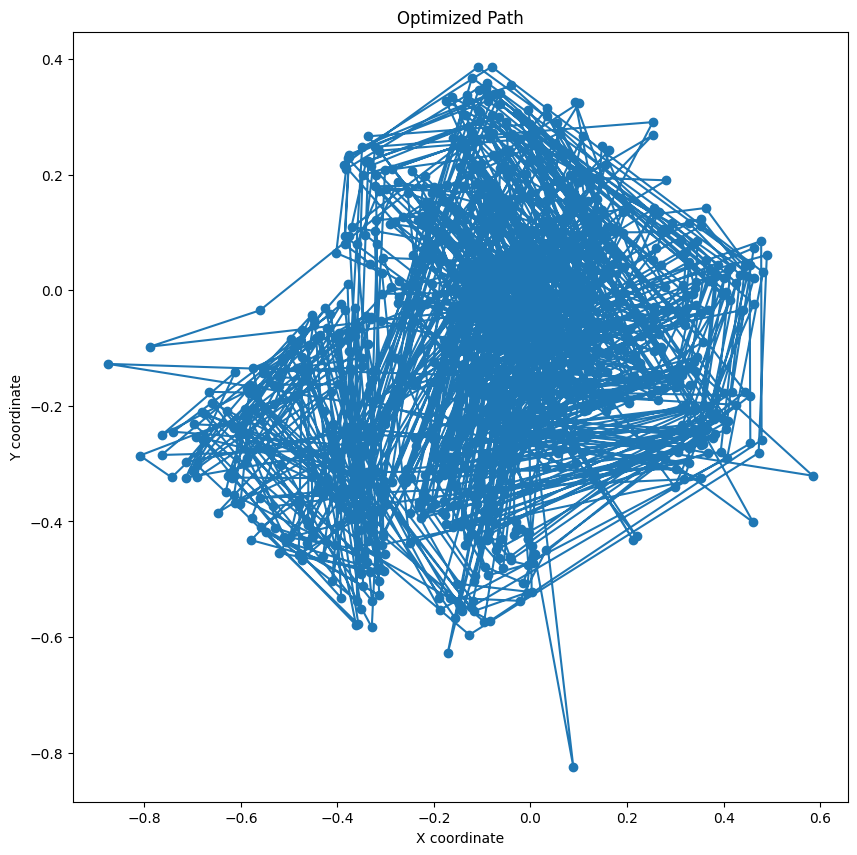

317.87054


In [23]:
print('best_cost : ', best_cost)

# 초기 Value Table 및 Policy 초기화
value_table, policy = initialize_value_policy(num_cities)

# 최적 경로 기반으로 Value Table 및 Policy 업데이트
value_table, policy = update_value_policy(value_table, policy, best_path, coordinates)
# Q Iteration을 사용하여 Q Table 및 Policy 갱신
distance_matrix = cdist(coordinates.numpy(), coordinates.numpy())
print(distance_matrix)
# initial_q = np.copy(value_table)#value_table 

# q_table, policy = q_iteration(distance_matrix, initial_q, episodes=1000)
q_table, policy = q_iteration(value_table, iterations=200)
# for q in q_table:
#     print(q)
#print("Policy:\n", policy)

# policy에 따른 경로 생성 및 시각화
policy_path = generate_path_from_policy(policy)
plot_path(policy_path, coordinates)
print(calculate_cost(policy_path, coordinates))

In [8]:
print(q_table)

[[   3.         -259.80604526 -259.80604526 ... -259.80604526
  -259.80604526 -259.80604526]
 [-259.80604526    3.         -259.80604526 ... -259.80604526
  -259.80604526 -259.80604526]
 [-259.80604526 -259.80604526    3.         ... -259.80604526
  -259.80604526 -259.80604526]
 ...
 [-259.80604526 -259.80604526 -259.80604526 ...    3.
  -259.80604526 -259.80604526]
 [-259.80604526 -259.80604526 -259.80604526 ... -259.80604526
     3.         -259.80604526]
 [-259.80604526 -259.80604526 -259.80604526 ... -259.80604526
  -259.80604526    3.        ]]


최적 비용: 121.94659241731279
경로: [555, 543, 590, 510, 560, 119, 250, 124, 238, 316, 947, 146, 235, 383, 161, 288, 799, 786, 295, 962, 281, 784, 71, 777, 788, 432, 785, 682, 399, 660, 609, 662, 597, 839, 983, 796, 357, 389, 319, 153, 420, 454, 409, 758, 205, 168, 96, 920, 39, 88, 57, 430, 990, 219, 321, 486, 81, 332, 494, 979, 471, 21, 743, 739, 981, 680, 697, 150, 16, 922, 944, 937, 386, 172, 426, 862, 949, 795, 706, 950, 924, 742, 176, 731, 868, 157, 700, 880, 187, 9, 463, 352, 374, 221, 398, 272, 459, 24, 184, 35, 36, 303, 385, 166, 268, 149, 30, 20, 110, 299, 3, 945, 246, 404, 345, 406, 879, 774, 127, 942, 76, 381, 424, 797, 789, 952, 939, 857, 935, 676, 831, 840, 732, 678, 681, 832, 736, 898, 902, 934, 722, 849, 749, 843, 763, 508, 80, 728, 675, 813, 724, 435, 872, 290, 232, 735, 850, 844, 220, 227, 804, 914, 930, 343, 759, 770, 912, 351, 741, 826, 817, 964, 899, 886, 462, 713, 212, 129, 973, 836, 709, 66, 495, 818, 871, 263, 206, 963, 926, 704, 918, 0, 970, 304, 892, 142, 234, 208, 4

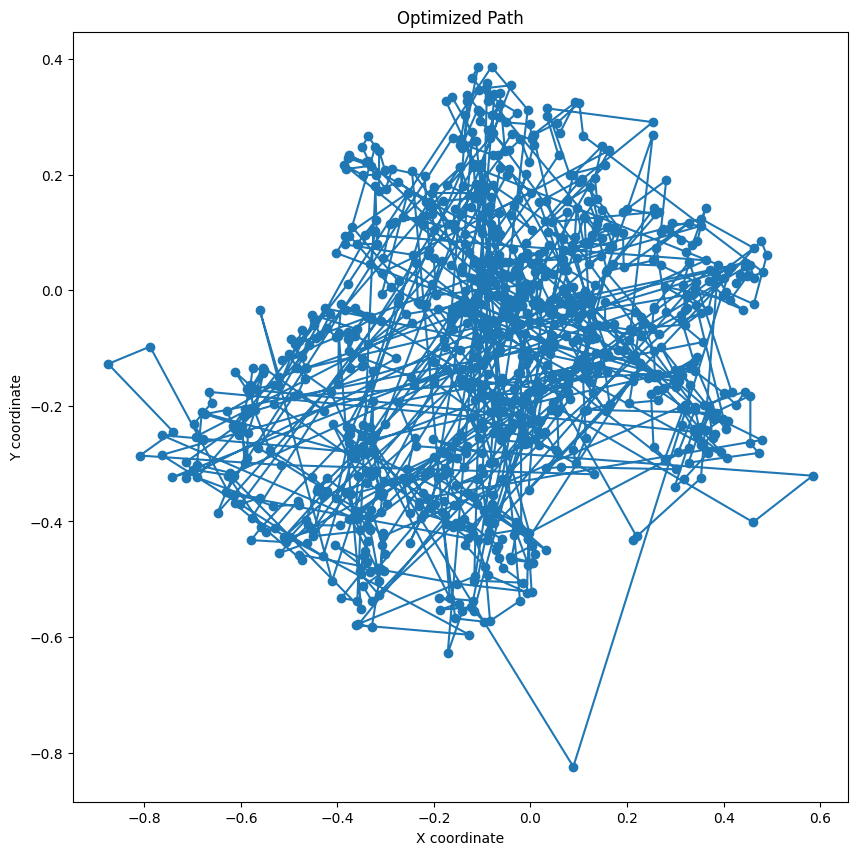

In [75]:
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# 데이터 로드 함수
def load_data(filepath):
    with open(filepath, mode='r', newline='') as file:
        data = [list(map(float, row)) for row in csv.reader(file)]
    return np.array(data)

# 경로 시각화 함수
def plot_path(path, coordinates):
    path = np.array(path + [path[0]])  # 경로 마감
    plt.figure(figsize=(10, 10))
    plt.plot(coordinates[path, 0], coordinates[path, 1], 'o-')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Optimized Path')
    plt.show()

# 거리 계산 함수
def calculate_cost(path, coordinates):
    cost = 0
    for i in range(len(path) - 1):
        cost += np.linalg.norm(coordinates[path[i]] - coordinates[path[i + 1]])
    return cost

# 초기 Q-테이블 생성 함수
def initialize_q_table(num_cities, value_table):
    q_table = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                q_table[i][j] = -value_table[i][j]
    return q_table

# Q-러닝 알고리즘
#새로운 Q-러닝 알고리즘
def q_learning(coordinates, q_table, num_episodes, alpha, gamma, epsilon):
    num_cities = len(coordinates)

    for episode in range(num_episodes):
        state = random.randint(0, num_cities - 1)
        visited = set([state])
        path = [state]

        while len(visited) < num_cities:
            if random.random() < epsilon:
                next_state = random.choice([city for city in range(num_cities) if city not in visited])
            else:
                next_state_values = q_table[state, :]
                next_state_values = np.ma.masked_array(next_state_values, mask=[i in visited for i in range(num_cities)])
                next_state = np.argmax(next_state_values)

            reward = -np.linalg.norm(coordinates[state] - coordinates[next_state])
            old_q_value = q_table[state, next_state]
            future_q_max = np.max(q_table[next_state, :])

            # TD 업데이트
            q_table[state, next_state] = old_q_value + alpha * (reward + gamma * future_q_max - old_q_value)

            state = next_state
            visited.add(state)
            path.append(state)

        path.append(path[0])
        episode_cost = calculate_cost(path, coordinates)

        # MC 업데이트: 경로상의 각 state-action 쌍을 업데이트
        for i in range(len(path) - 1):
            start, end = path[i], path[i + 1]
            reward = -np.linalg.norm(coordinates[start] - coordinates[end])
            q_table[start, end] = q_table[start, end] + alpha * (reward - q_table[start, end])

    return q_table, path


# 데이터 로드
#coordinates = load_data('2024_AI_TSP.csv')
num_cities = 998 #len(coordinates)

# 초기화된 value_table을 가져오는 부분 (예시로 랜덤 값 사용)
value_table = np.random.rand(num_cities, num_cities)

# 기존 Value Table을 기반으로 Q-테이블 초기화
q_table = initialize_q_table(num_cities, value_table)

# Q-러닝 수행
q_table, best_path = q_learning(coordinates, q_table, num_episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1)
best_cost = calculate_cost(best_path, coordinates)

# 결과 출력 및 경로 시각화
print("최적 비용:", best_cost)
print("경로:", best_path)
print("Q-테이블:\n", q_table)
plot_path(best_path, coordinates)
